In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class RNN:
    def __init__(self, input_size, hidden_size, output_size, init_method="random"):
        self.weights_ih, self.weights_hh, self.weights_ho = self.initialize_weights(input_size, hidden_size, output_size, init_method)
        self.bias_h = np.zeros((1, hidden_size))
        self.bias_o = np.zeros((1, output_size))
        self.hidden_size = hidden_size

    def initialize_weights(self, input_size, hidden_size, output_size, method):
        if method == "random":
            weights_ih = np.random.randn(input_size, hidden_size) * 0.01
            weights_hh = np.random.randn(hidden_size, hidden_size) * 0.01
            weights_ho = np.random.randn(hidden_size, output_size) * 0.01
        elif method == "xavier":
            weights_ih = np.random.randn(input_size, hidden_size) / np.sqrt(input_size / 2)
            weights_hh = np.random.randn(hidden_size, hidden_size) / np.sqrt(hidden_size / 2)
            weights_ho = np.random.randn(hidden_size, output_size) / np.sqrt(hidden_size / 2)
        elif method == "he":
            weights_ih = np.random.randn(input_size, hidden_size) * np.sqrt(2 / input_size)
            weights_hh = np.random.randn(hidden_size, hidden_size) * np.sqrt(2 / hidden_size)
            weights_ho = np.random.randn(hidden_size, output_size) * np.sqrt(2 / hidden_size)
        else:
            raise ValueError("Invalid initialization method")
        return weights_ih, weights_hh, weights_ho


    def forward(self, inputs):
        h = np.zeros((1, self.hidden_size))
        self.last_inputs = inputs
        self.last_hs = {0: h}

        for i, x in enumerate(inputs):
            x = x.reshape(1, -1)  # Ensure x is a row vector
            h = np.tanh(np.dot(x, self.weights_ih) + np.dot(h, self.weights_hh) + self.bias_h)
            self.last_hs[i + 1] = h

        y = np.dot(h, self.weights_ho) + self.bias_o
        self.last_outputs = y
        return y

    def backprop(self, d_y, learning_rate, clip_value=1):
        n = len(self.last_inputs)

        d_y_pred = (self.last_outputs - d_y) / d_y.size
        d_Whh = np.zeros_like(self.weights_hh)
        d_Wxh = np.zeros_like(self.weights_ih)
        d_Why = np.zeros_like(self.weights_ho)
        d_bh = np.zeros_like(self.bias_h)
        d_by = np.zeros_like(self.bias_o)
        d_h = np.dot(d_y_pred, self.weights_ho.T)

        for t in reversed(range(1, n + 1)):
            d_h_raw = (1 - self.last_hs[t] ** 2) * d_h
            d_bh += d_h_raw
            d_Whh += np.dot(self.last_hs[t - 1].T, d_h_raw)
            d_Wxh += np.dot(self.last_inputs[t - 1].reshape(1, -1).T, d_h_raw)
            d_h = np.dot(d_h_raw, self.weights_hh.T)

        for d in [d_Wxh, d_Whh, d_Why, d_bh, d_by]:
            np.clip(d, -clip_value, clip_value, out=d)
            
        self.weights_ih -= learning_rate * d_Wxh
        self.weights_hh -= learning_rate * d_Whh
        self.weights_ho -= learning_rate * d_Why
        self.bias_h -= learning_rate * d_bh
        self.bias_o -= learning_rate * d_by

In [33]:
class EarlyStopping:
   def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

   def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
    
        elif score < self.best_score + self.delta:
            self.counter += 1
            
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

In [34]:
class RNNTrainer:
    def __init__(self, model, loss_func='mse'):
        self.model = model
        self.loss_func = loss_func
        self.train_loss = []
        self.val_loss = []
        self.gradients = []  # Initialize gradients attribute

    def calculate_loss(self, y_true, y_pred):
        if self.loss_func == 'mse':
            return np.mean((y_pred - y_true) ** 2)
        elif self.loss_func == 'log_loss':
            return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        elif self.loss_func == 'categorical_crossentropy':
            return -np.mean(y_true * np.log(y_pred))
        else:
            raise ValueError('Invalid loss function')

    def train(self, train_data, train_labels, val_data, val_labels, epochs, learning_rate, early_stopping=True, patience=10, clip_value=1):
        if early_stopping:
            early_stopping = EarlyStopping(patience=patience, verbose=True)

        for epoch in range(epochs):
            epoch_gradients = []  # Collect gradients per epoch
            
            for X_train, y_train in zip(train_data, train_labels):
                outputs = self.model.forward(X_train)
                self.model.backprop(y_train, learning_rate, clip_value)

                # Calculate train loss
                train_loss = self.calculate_loss(y_train, outputs)
                self.train_loss.append(train_loss)

                # Store gradients
                epoch_gradients.append([
                    np.mean(self.model.weights_ih),  # Gradient for weights_ih
                    np.mean(self.model.weights_hh),  # Gradient for weights_hh
                    np.mean(self.model.weights_ho)   # Gradient for weights_ho
                ])
            
            # Append gradients of this epoch
            self.gradients.append(epoch_gradients)

            # Calculate validation loss
            val_loss_epoch = []
            for X_val, y_val in zip(val_data, val_labels):
                val_outputs = self.model.forward(X_val)
                val_loss = self.calculate_loss(y_val, val_outputs)
                val_loss_epoch.append(val_loss)
            val_loss = np.mean(val_loss_epoch)
            self.val_loss.append(val_loss)

            # Check for early stopping
            if early_stopping:
                early_stopping(val_loss)
                if early_stopping.early_stop:
                    print(f"Early stopping at epoch {epoch} | Best validation loss = {-early_stopping.best_score:.3f}")
                    break

            if epoch % 10 == 0:
                print(f'Epoch {epoch}: Train loss = {train_loss:.4f}, Validation loss = {val_loss:.4f}')

    def plot_gradients(self):
        # Transpose gradients to plot over time (epochs)
        gradients_array = np.array(self.gradients)
        
        for i in range(gradients_array.shape[2]):  # For each weight matrix (ih, hh, ho)
            plt.plot(gradients_array[:, :, i].flatten(), label=f'Gradient {i}')

        plt.xlabel('Epoch')
        plt.ylabel('Gradient Value')
        plt.title('Gradients over Epochs')
        plt.legend()
        plt.show()


In [35]:
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv'
dataset = TimeSeriesDataset(url, look_back=1)
trainX, trainY, testX, testY = dataset.get_train_test()

In [36]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [37]:
look_back = 1
rnn = RNN(look_back, 256, 1, init_method='xavier')
trainer = RNNTrainer(rnn, 'mse')
trainer.train(trainX, trainY, testX, testY, epochs=100, learning_rate=0.01, early_stopping=True, patience=10, clip_value=1)

Epoch 0: Train loss = 0.0002, Validation loss = 0.0758
Epoch 10: Train loss = 0.0054, Validation loss = 0.0103
Epoch 20: Train loss = 0.0052, Validation loss = 0.0102
Epoch 30: Train loss = 0.0051, Validation loss = 0.0102
Epoch 40: Train loss = 0.0050, Validation loss = 0.0102
Epoch 50: Train loss = 0.0049, Validation loss = 0.0102
Epoch 60: Train loss = 0.0049, Validation loss = 0.0101
Epoch 70: Train loss = 0.0048, Validation loss = 0.0101
Epoch 80: Train loss = 0.0047, Validation loss = 0.0101
Epoch 90: Train loss = 0.0047, Validation loss = 0.0101


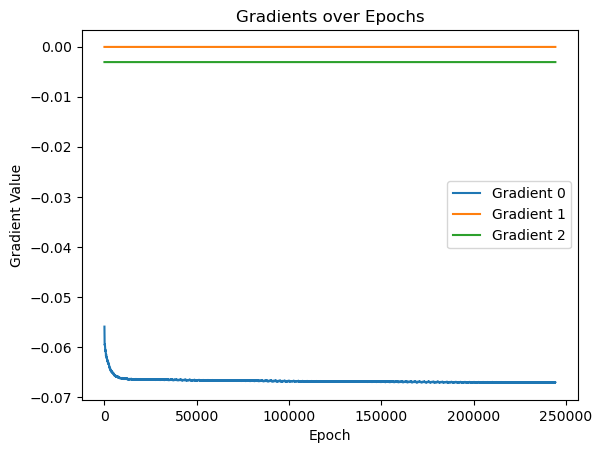

In [38]:
trainer.plot_gradients()